In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
os.chdir("../")

import pandas as pd
import numpy as np

from tqdm import tqdm_notebook as tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import stats
from deepflow.plotting_utils import colorbar
from deepflow.plotting_utils import get_unconditionals
from deepflow.plotting_utils import plot_misfit_histograms

In [11]:
plot = True
working_dir = './results/runs/'
perm = "low_perm"

In [4]:
unc_curves, unc_poros, unc_perms, unc_zs, unc_misfits = get_unconditionals(working_dir, perm)

99
199
299
399
499
599
699
799
899
999


In [5]:
# inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex': True,
    'figure.figsize': [14, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

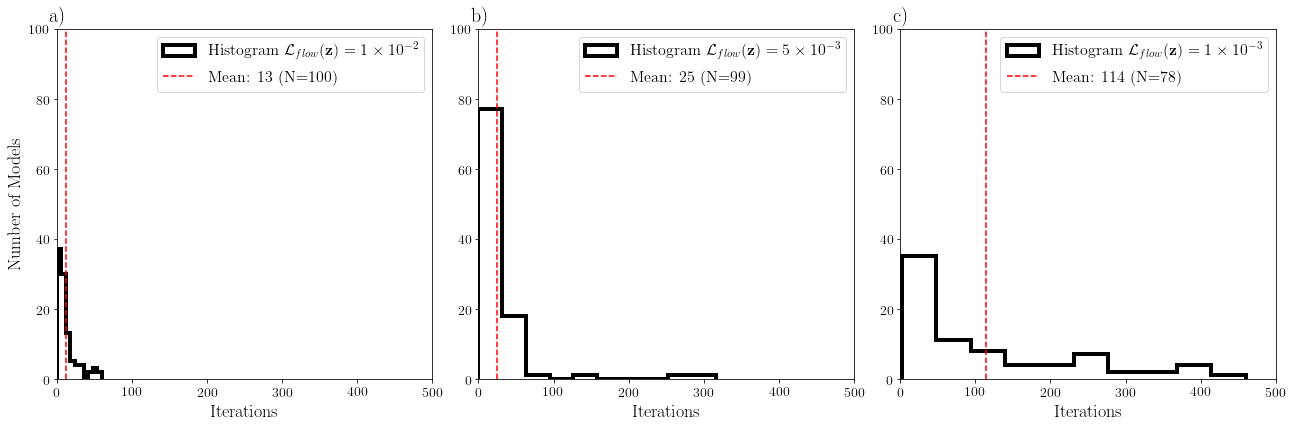

In [12]:
misfits = np.load("./results/misfits/low_perm/misfits_flow_adam_gauss.npy")

fig, axarr = plt.subplots(1, 3, figsize=(6*3, 6))
plot_misfit_histograms(axarr, misfits)
fig.tight_layout()
    
if plot:
    plt.savefig("./results/figures/error_threshold_iterations_flow.png", dpi=300, bbox_inches="tight")

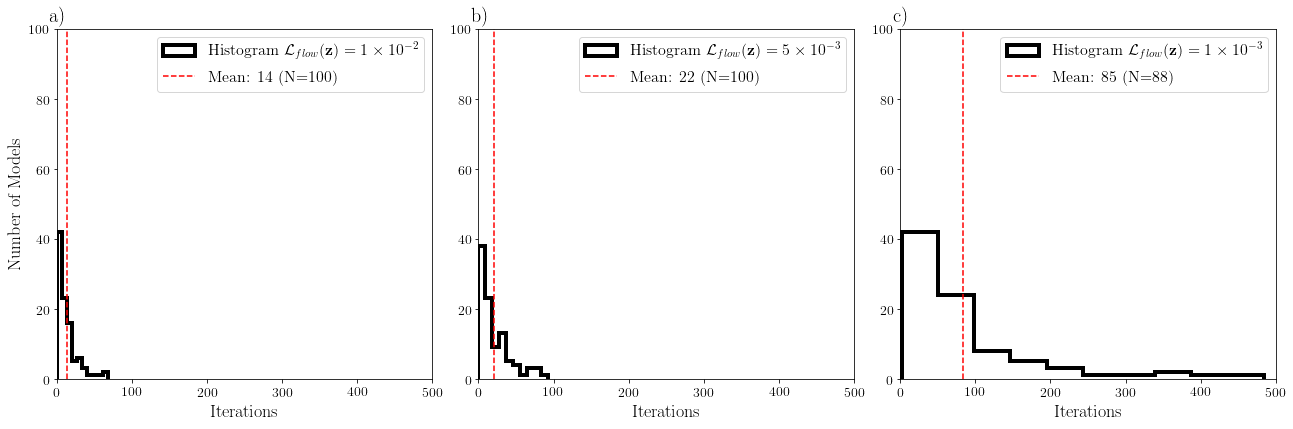

In [13]:
misfits = np.load("./results/misfits/low_perm/misfits_flowwells_adam_gauss.npy")

fig, axarr = plt.subplots(1, 3, figsize=(6*3, 6))
plot_misfit_histograms(axarr, misfits)
fig.tight_layout()

if plot:
    plt.savefig("./results/figures/error_threshold_iterations_flowwells.png", dpi=300, bbox_inches="tight")

[<matplotlib.patches.Polygon object at 0x7faaad775a58>, <matplotlib.patches.Polygon object at 0x7faaad775b70>]
[<matplotlib.patches.Polygon object at 0x7faaad24bc50>, <matplotlib.patches.Polygon object at 0x7faaad24bf98>]


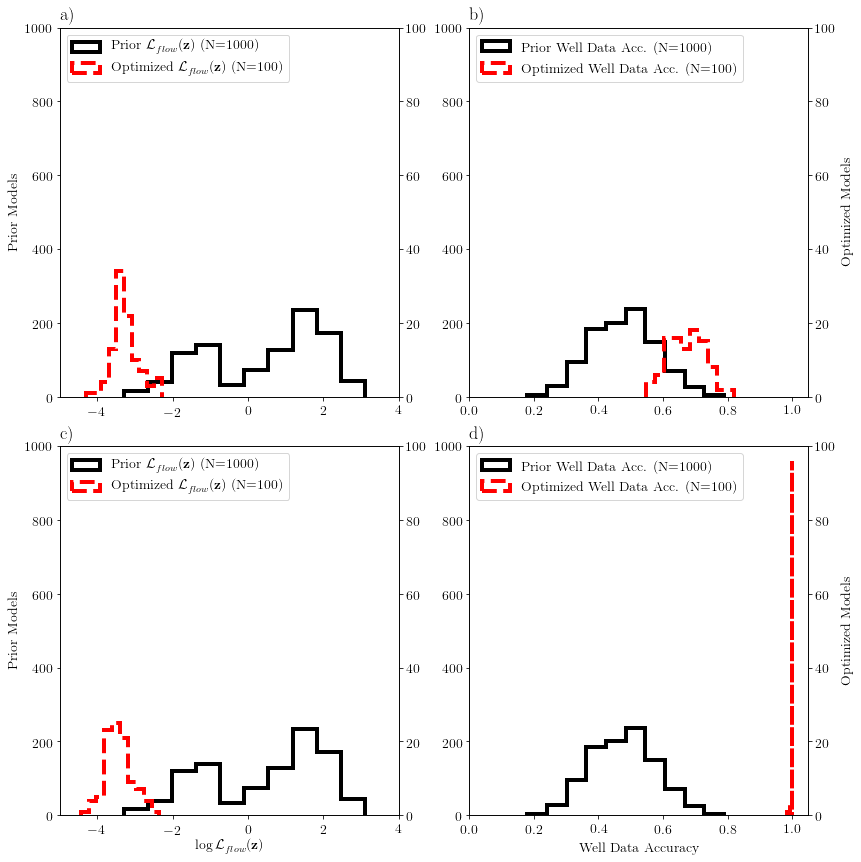

In [14]:
misfits_flow = np.load("./results/misfits/low_perm/misfits_flow_adam_gauss.npy")
misfits_flowwells = np.load("./results/misfits/low_perm/misfits_flowwells_adam_gauss.npy")

f_error_flowwells = pd.DataFrame([m[:, 3] for m in misfits_flowwells]).min(axis=1)
well_acc_flowwells = pd.DataFrame([m[:, 4] for m in misfits_flowwells]).max(axis=1)

f_error_flow = pd.DataFrame([m[:, 3] for m in misfits_flow]).min(axis=1)
well_acc_flow = pd.DataFrame([m[:, 4] for m in misfits_flow]).max(axis=1)

fig, axarr = plt.subplots(2, 2, figsize=(12, 12))

axarr = axarr.flatten()

ax1 = axarr[0].twinx()
h1 = axarr[0].hist(np.log10(unc_misfits[:, 0, 0, 0]), 
               histtype="step", color="black", linestyle="-", lw=4, label=r'Prior $\mathcal{L}_{flow}(\mathbf{z})$ (N=1000)')
h2 = ax1.hist(np.log10(f_error_flow.values.flatten()), 
         histtype="step", color="red", linestyle="--", lw=4, label=r'Optimized $\mathcal{L}_{flow}(\mathbf{z})$ (N=100)')

axarr[0].set_ylim(0, 1000)
axarr[0].set_xlim(-5, 4)
ax1.set_ylim(0, 100)   
ax1.set_xlim(-5, 4)

# added these three lines
m=2
lns = list(h1[m])+list(h2[m])
print(lns)

labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=14, loc=2)

ax2 = axarr[1].twinx()
h3 = axarr[1].hist(unc_misfits[:, 0, 0, 2], 
               histtype="step", color="black", linestyle="-", lw=4, label=r'Prior Well Data Acc. (N=1000)')
h4= ax2.hist(well_acc_flow.values.flatten(), 
         histtype="step", color="red", linestyle="--", lw=4, label=r'Optimized Well Data Acc. (N=100)')

axarr[1].set_ylim(0, 1000)
axarr[1].set_xlim(0, 1)
ax2.set_ylim(0, 100)   
ax2.set_xlim(0, 1.05)

lns = list(h3[m])+list(h4[m])
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, fontsize=14, loc=2)


ax3 = axarr[2].twinx()
h5 = axarr[2].hist(np.log10(unc_misfits[:, 0, 0, 0]), 
               histtype="step", color="black", linestyle="-", lw=4, label=r'Prior $\mathcal{L}_{flow}(\mathbf{z})$ (N=1000)')
h6 = ax3.hist(np.log10(f_error_flowwells.values.flatten()), 
         histtype="step", color="red", linestyle="--", lw=4, label=r'Optimized $\mathcal{L}_{flow}(\mathbf{z})$ (N=100)')

axarr[2].set_ylim(0, 1000)
axarr[2].set_xlim(-4, 4)
ax3.set_ylim(0, 100)   
ax3.set_xlim(-5, 4)

lns = list(h5[m])+list(h6[m])
print(lns)

labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, fontsize=14, loc=2)

ax4 = axarr[3].twinx()
h7 = axarr[3].hist(unc_misfits[:, 0, 0, 2], 
               histtype="step", color="black", linestyle="-", lw=4, label=r'Prior Well Data Acc. (N=1000)')
h8 = ax4.hist(well_acc_flowwells.values.flatten(), 
         histtype="step", color="red", linestyle="--", lw=4, label=r'Optimized Well Data Acc. (N=100)')

axarr[3].set_ylim(0, 1000)
axarr[3].set_xlim(0, 1)
ax4.set_ylim(0, 100)   
ax4.set_xlim(0, 1.05)

lns = list(h7[m])+list(h8[m])
labs = [l.get_label() for l in lns]
ax4.legend(lns, labs, fontsize=14, loc=2)

axarr[0].set_ylabel("Prior Models", fontsize=14)
ax2.set_ylabel("Optimized Models", fontsize=14)

axarr[2].set_xlabel(r"$\log{\mathcal{L}_{flow}(\mathbf{z})}$", fontsize=14)
axarr[2].set_ylabel("Prior Models", fontsize=14)

ax4.set_ylabel("Optimized Models", fontsize=14)
axarr[3].set_xlabel(r"Well Data Accuracy", fontsize=14)

for ax, label, left in zip([ax1, ax2, ax3, ax4], ["a)", "b)", "c)", "d)"], [-5, -0.00, -5, -0.00]):
    ax.text(left, 102, label, fontsize=18)

fig.tight_layout()

if plot:
    plt.savefig("./results/figures/histogram_comparisons_prior_optimized.png", dpi=300, bbox_inches="tight")

In [35]:
misfits_flow = np.load("./results/misfits/low_perm/misfits_flow_adam_gauss.npy")
misfits_flowwells = np.load("./results/misfits/low_perm/misfits_flowwells_adam_gauss.npy")

f_error_flowwells = pd.DataFrame([m[:, 3] for m in misfits_flowwells])

f_error_flow = pd.DataFrame([m[:, 3] for m in misfits_flow]).min(axis=1)


In [36]:
print(f_error_flowwells.shape)

(100, 500)


In [37]:
delta = [np.nanmax(f)-np.nanmin(f) for f in f_error_flowwells.values]
minims =  [[np.nanmax(f), np.nanmin(f)] for f in f_error_flowwells.values]
greatest = np.argmax(delta)
print(greatest, minims[greatest])

66 [784.260009765625, 0.00019347475608810782]
